In [21]:
import os
import shutil
import numpy as np
import pandas as pd

import matplotlib.pylab as pylab
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)

params = {'legend.fontsize': 20,
          'figure.figsize': (8, 5),
         'axes.labelsize': 24,
         'axes.titlesize':16,
         'xtick.labelsize':18,
         'ytick.labelsize':18}
mpl.rc('font',family='Times New Roman')
pylab.rcParams.update(params)
cmap = plt.cm.viridis
count = 10
color = [cmap(round(i/count*cmap.N)) for i in range(count)]

In [5]:
dft = pd.read_csv('data/defect/dft_info.csv')
me = pd.read_csv('data/defect/ME_FF.csv')
ad = pd.read_csv('data/defect/Adsorption_ethene_ethane.csv')

temp = pd.read_csv('data/Data_S1.csv')
feature = temp[temp['molecule']=='ethane'][temp.columns[2:101]]
feature['MOF'] = temp[temp['molecule']=='ethane']['MOF']

df = pd.DataFrame()
temp = dft[dft['conc']=='0']
temp['MOF'] = [x.split('_')[0] for x in temp['mof'] ] 
df['MOF'] = temp['MOF'] 
df['MPDC'] = temp['max']

df = pd.merge(df,feature,on='MOF')

megnet = pd.read_csv('data/megnet_properties.csv')
df = pd.merge(df,megnet,on='MOF')

# feature scale
df_norm = df[df.columns[1::]]
df_norm = df_norm.astype(float)
df_norm = df_norm.loc[:, [len(np.unique(df_norm[x])) > 2 for x in df_norm.columns]]
df_norm = (df_norm-df_norm.min())/(df_norm.max()-df_norm.min())

df_norm = df_norm.dropna(axis=1)

/tmp/ipykernel_3079629/3028468144.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['MOF'] = [x.split('_')[0] for x in temp['mof'] ]


Best Parameters:  {'alpha': 10.0}
R-squared: 0.2013745145697745


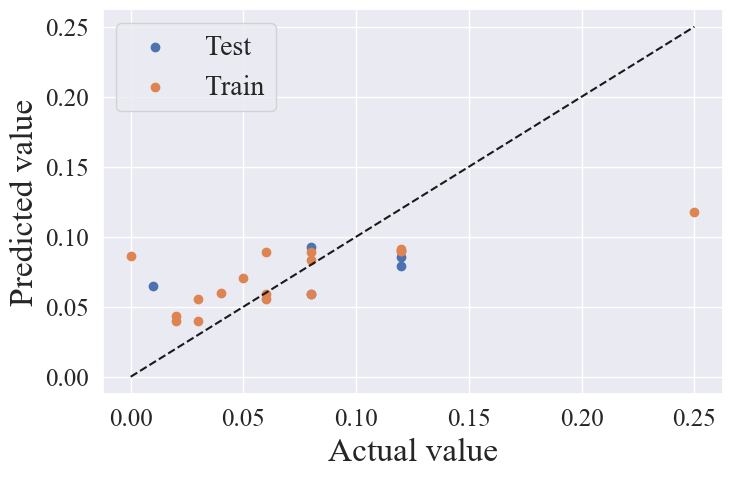

In [22]:
# use easy to get features to fit a regression model for MPDC 

from sklearn.linear_model import Lasso,LinearRegression,Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

features_selected = list(df.columns[2:5]) + list(df.columns[30::])
X, y = df_norm[features_selected], df['MPDC']
# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create an instance of the Lasso regression model
model = Ridge(fit_intercept= True)

# Define the grid of hyperparameters to search
param_grid = {'alpha': [0.1, 1.0, 10.0]}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameter value found
print("Best Parameters: ", grid_search.best_params_)

# Create a new Lasso regression model with the best hyperparameter
best_model = grid_search.best_estimator_

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Predict the target variable for the test data
predictions = best_model.predict(X_test)

# Evaluate the model
#mse = mean_squared_error(y_test, predictions)
#print("Mean Squared Error:", mse)

plt.scatter(y_test, predictions,label = 'Test')


predictions2 = best_model.predict(X_train)
plt.scatter(y_train, predictions2, label = 'Train')
plt.plot([0,0.25],[0,0.25],color='k',ls='--')

r2 = r2_score(y_test, predictions)

# Print the R-squared value
print("R-squared:", r2)

plt.legend()
plt.xlabel('Actual value')
plt.ylabel("Predicted value")
plt.savefig('fig/defect_GL_regression.jpg',dpi=500,bbox_inches='tight')

Best Hyperparameters:
{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 10}

Test Set R^2 Score: -0.011598619424872725


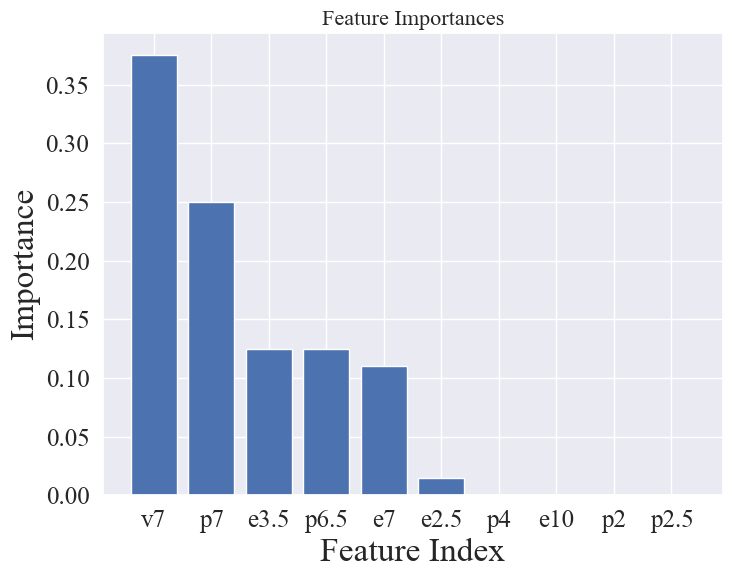

In [35]:
from sklearn.ensemble import RandomForestRegressor


# Create a Random Forest regressor
rf = RandomForestRegressor()

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [5,10,15,20,25],
    'max_depth': [1,3,5],
    'min_samples_split': [2, 5, 10]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)


# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

# Evaluate on test set
predictions = best_model.predict(X_test)
test_score = r2_score(y_test, predictions)
print("\nTest Set R^2 Score:", test_score)

# Get feature importances
importances = best_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[indices][0:10], color='b', align='center')
plt.xticks(range(10), X.columns[indices[0:10]])
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()
